## Step 1: Install & Import Required Libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from datetime import datetime
import matplotlib.dates as mdates

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

import cvxpy as cp

from sklearn.metrics import r2_score



# Set plotting style
sns.set(style='whitegrid')

## Step 2: Define Tickers and Download Historical Data

In [ ]:
# Define tickers and time period
tickers = [
    "XOM", "CVX", "SHEL", "TTFNF", "TTE", "COP", "WMB", "EOG", "LNG", "OKE",
    "PSX", "MPC", "HES", "FANG", "TRGP", "VLO", "IMO", "TPL", "CQP", "EXE",
    "DTM", "SUN", "NFG", "DCCPF", "GZPZF", "CHRD", "LB", "DLKGF", "GPOR",
    "TRRVF", "NRP", "LEU", "SBR", "PNRG", "FGPRB", "PDER", "AMEN", "RSRV",
    "TRKX", "LCNTU", "VIRDY", "CNR", "EXEEL", "EXEEZ", "PZZPF", "TTYP"
]

start_date = '2010-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
# end_date = '2025-04-30'

# Download price data
def download_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    close = data['Close']
    #returns = close.pct_change().dropna()
    return close


Close = download_data(tickers, start_date, end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  46 of 46 completed


In [ ]:
print(Close.shape)
Close.head()

(3852, 46)


Ticker,AMEN,CHRD,CNR,COP,CQP,CVX,DCCPF,DLKGF,DTM,EOG,...,TRGP,TRKX,TRRVF,TTE,TTFNF,TTYP,VIRDY,VLO,WMB,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,98.087914,NaN,NaN,23.572039,4.742821,43.122471,NaN,NaN,NaN,36.268818,...,NaN,NaN,NaN,26.807287,NaN,7.263494,41279.691406,9.982555,8.169253,38.923946
2010-01-05,98.087914,NaN,NaN,23.594444,4.922261,43.427944,NaN,NaN,NaN,35.824394,...,NaN,NaN,NaN,26.868330,NaN,7.263494,42157.988281,10.239230,8.271317,39.075924
2010-01-06,98.087914,NaN,NaN,23.764812,5.055962,43.433380,NaN,NaN,NaN,35.943630,...,NaN,NaN,NaN,26.860191,NaN,7.263494,42908.191406,10.495910,8.539722,39.413662
2010-01-07,98.087914,NaN,NaN,23.670668,5.316323,43.269737,NaN,NaN,NaN,35.607601,...,NaN,NaN,NaN,26.799154,NaN,7.526936,44591.582031,10.574032,8.479238,39.289822
2010-01-08,98.087914,NaN,NaN,23.876881,5.136886,43.346096,NaN,NaN,NaN,35.788273,...,NaN,NaN,NaN,26.961924,NaN,7.526936,45872.425781,10.428952,8.547279,39.132210


In [ ]:
Close.tail()

Ticker,AMEN,CHRD,CNR,COP,CQP,CVX,DCCPF,DLKGF,DTM,EOG,...,TRGP,TRKX,TRRVF,TTE,TTFNF,TTYP,VIRDY,VLO,WMB,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-21,490.000000,92.839996,73.000000,87.550003,57.740002,133.729996,67.25,144.070007,92.919998,109.110001,...,164.539993,375.0,98.0,57.889999,57.830002,58.0,73.0,108.839996,56.439999,105.349998
2025-04-22,485.970001,94.290001,74.099998,89.760002,58.889999,137.300003,67.25,158.000000,95.599998,111.320000,...,170.899994,375.0,98.0,59.389999,59.410000,58.0,73.0,112.459999,58.200001,108.300003
2025-04-23,485.970001,92.790001,73.779999,89.930000,59.160000,136.679993,67.25,158.000000,96.919998,111.570000,...,172.350006,375.0,98.0,58.700001,58.099998,58.0,73.0,114.500000,58.480000,107.370003
2025-04-24,485.970001,94.750000,75.190002,91.800003,59.209999,139.070007,67.25,158.000000,98.910004,113.459999,...,177.000000,375.0,98.0,59.279999,58.910000,58.0,73.0,113.360001,59.610001,108.629997
2025-04-25,495.000000,94.620003,74.120003,91.720001,59.500000,138.729996,67.25,158.000000,98.709999,113.070000,...,177.619995,375.0,105.0,59.950001,60.549999,58.0,73.0,113.870003,59.029999,108.570000


Before we proceed to the next step wchich is EDA, we would like to remove tickers without complete data.

In [ ]:
# Handle missing data
def clean_data(df, threshold=1.0):
    # Drop stocks with more than threshold% missing values
    df = df.dropna(axis=1, thresh=int(df.shape[0] * threshold))
    # Forward fill then backfill remaining missing values
    df = df.ffill().bfill()
    return df

Prices = clean_data(Close)

# Show summary
print("Downloaded data shape:", Prices.shape)
print("Remaining tickers after filtering:", Prices.columns.tolist())

Downloaded data shape: (3852, 24)
Remaining tickers after filtering: ['AMEN', 'COP', 'CQP', 'CVX', 'EOG', 'HES', 'IMO', 'LEU', 'LNG', 'NFG', 'NRP', 'OKE', 'PDER', 'PNRG', 'RSRV', 'SBR', 'SHEL', 'TPL', 'TTE', 'TTYP', 'VIRDY', 'VLO', 'WMB', 'XOM']


## Step 3: Calculate Daily Returns

In [ ]:
returns = Prices.pct_change().dropna()
returns.head()

Ticker,AMEN,COP,CQP,CVX,EOG,HES,IMO,LEU,LNG,NFG,...,RSRV,SBR,SHEL,TPL,TTE,TTYP,VIRDY,VLO,WMB,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.0,0.000951,0.037834,0.007084,-0.012254,0.006175,0.006337,-0.004819,0.016064,0.005724,...,-0.050847,0.010653,0.001123,0.056643,0.002277,0.000000,0.021277,0.025712,0.012494,0.003904
2010-01-06,0.0,0.007221,0.027162,0.000125,0.003328,0.002675,0.004786,0.033898,0.090909,0.002159,...,0.000000,0.009824,-0.008170,-0.025341,-0.000303,0.000000,0.017795,0.025068,0.032450,0.008643
2010-01-07,0.0,-0.003962,0.051496,-0.003768,-0.009349,0.019147,-0.017297,0.025761,0.061594,-0.005875,...,0.000000,0.015183,-0.004846,-0.008334,-0.002272,0.036269,0.039232,0.007443,-0.007083,-0.003142
2010-01-08,0.0,0.008712,-0.033752,0.001765,0.005074,0.013705,0.007908,-0.018265,0.075085,0.006501,...,0.000000,0.009115,-0.001460,-0.025210,0.006074,0.000000,0.028724,-0.013720,0.008025,-0.004012
2010-01-11,0.0,0.005821,0.032877,0.017743,-0.009188,-0.010482,0.002784,-0.006977,0.126984,0.015658,...,-0.146250,-0.005558,0.015605,-0.002758,0.014941,0.000000,0.064619,-0.009631,-0.006192,0.011220


In [ ]:
returns_monthly = Prices.resample('M').last().pct_change().dropna()
returns_monthly.tail()

<ipython-input-7-8a89f16028e2>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns_monthly = Prices.resample('M').last().pct_change().dropna()


Ticker,AMEN,COP,CQP,CVX,EOG,HES,IMO,LEU,LNG,NFG,...,RSRV,SBR,SHEL,TPL,TTE,TTYP,VIRDY,VLO,WMB,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-31,-0.022958,-0.084641,-0.088069,-0.105539,-0.080144,-0.093042,-0.166667,-0.268022,-0.040802,-0.043347,...,-0.018000,0.001986,-0.032283,-0.308122,-0.045625,0.008217,0.000000,-0.118565,-0.067159,-0.088081
2025-01-31,0.026000,-0.003428,0.155120,0.030033,0.033486,0.045260,0.081818,0.235550,0.040862,0.154087,...,0.092390,0.028256,0.051077,0.172891,0.064771,-0.042647,0.000000,0.093778,0.024205,-0.006879
2025-02-28,0.095517,0.011379,0.118239,0.075001,0.009142,0.071280,0.018007,0.102430,0.024297,0.073825,...,-0.033898,-0.005394,0.035454,0.100819,0.037911,-0.009217,0.387206,-0.017068,0.049612,0.051444
2025-03-31,0.021457,0.059203,-0.024664,0.054659,0.010241,0.076077,0.066038,-0.314339,0.012426,0.059986,...,0.011696,0.039673,0.086273,-0.071062,0.088418,0.000000,0.082969,0.010250,0.036381,0.068266
2025-04-30,-0.131579,-0.126643,-0.099031,-0.170721,-0.110222,-0.171477,-0.047013,0.118148,0.007692,-0.016290,...,-0.126590,-0.000471,-0.101255,0.007276,-0.073273,-0.100775,0.177419,-0.137806,-0.012216,-0.087110


## Step 4: Basic EDA

### 4.1 Summary Statistics

In [ ]:
# Summary statistics of returns
summary_stats = returns.describe().T[['mean', 'std', 'min', 'max']]
summary_stats['skew'] = returns.skew()
summary_stats['kurtosis'] = returns.kurtosis()
summary_stats.sort_values(by='mean', ascending=False).head(10)

,mean,std,min,max,skew,kurtosis
Ticker,,,,,,
VIRDY,0.016707,1.084843,-0.990000,67.253969,61.871718,3835.735297
LNG,0.001687,0.032153,-0.357657,0.686275,2.809970,65.202726
TPL,0.001658,0.026186,-0.248859,0.261400,0.328547,10.608777
AMEN,0.001442,0.045779,-0.327619,0.495726,1.547465,23.885534
LEU,0.001297,0.067410,-0.601589,1.438944,5.121444,94.453717
TTYP,0.001159,0.035843,-0.371428,0.605504,3.157941,72.562942
PNRG,0.001054,0.036120,-0.303874,0.579477,1.486955,28.507207
VLO,0.000934,0.024598,-0.192209,0.312025,0.429661,11.994133
CQP,0.000904,0.022059,-0.245628,0.160919,-0.838146,14.238471


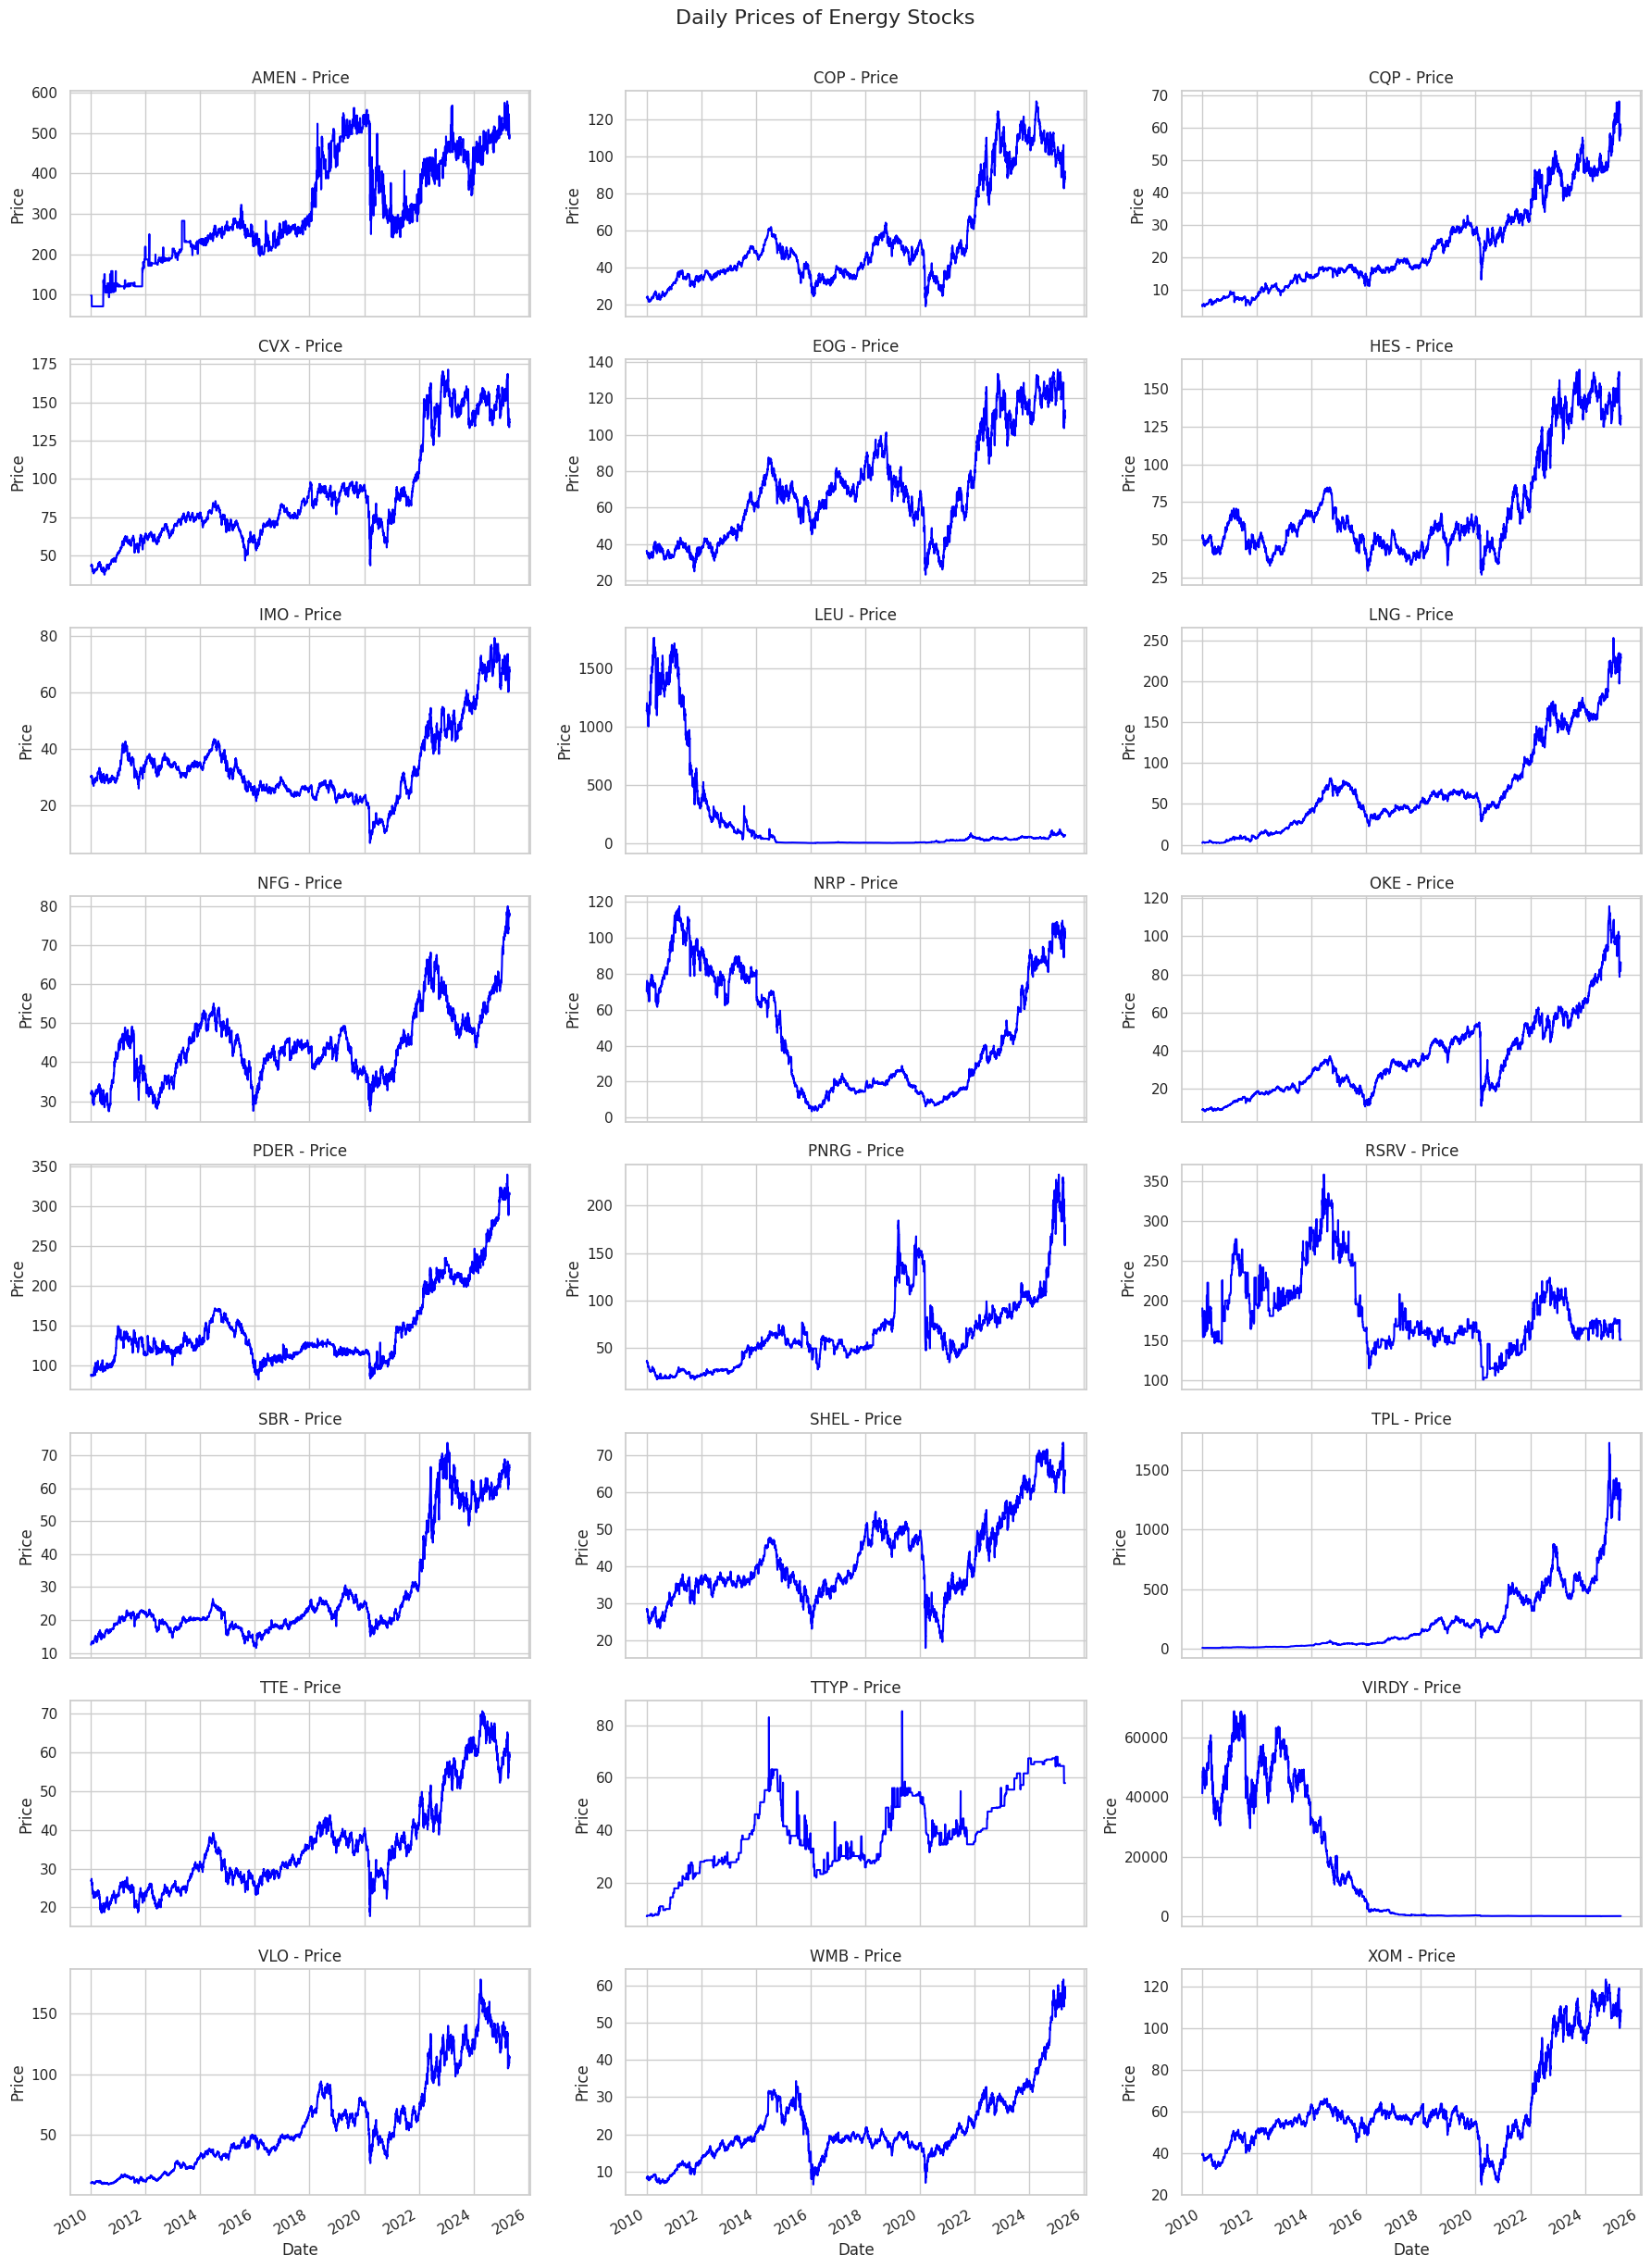

In [ ]:
tickers = Prices.columns
num_tickers = len(tickers)
cols = 3  # 3 columns in the subplot grid
rows = math.ceil(num_tickers / cols)

# Plot Prices
fig1, axes1 = plt.subplots(rows, cols, figsize=(18, rows * 3), sharex=True)
axes1 = axes1.flatten()

for i, ticker in enumerate(tickers):
    ax = axes1[i]
    Prices[ticker].plot(ax=ax, title=f"{ticker} - Price", color='blue')
    ax.set_ylabel("Price")
    ax.grid(True)

# Remove unused subplots
for j in range(i + 1, len(axes1)):
    fig1.delaxes(axes1[j])

plt.tight_layout()
plt.suptitle("Daily Prices of Energy Stocks", fontsize=16, y=1.02)
plt.show()

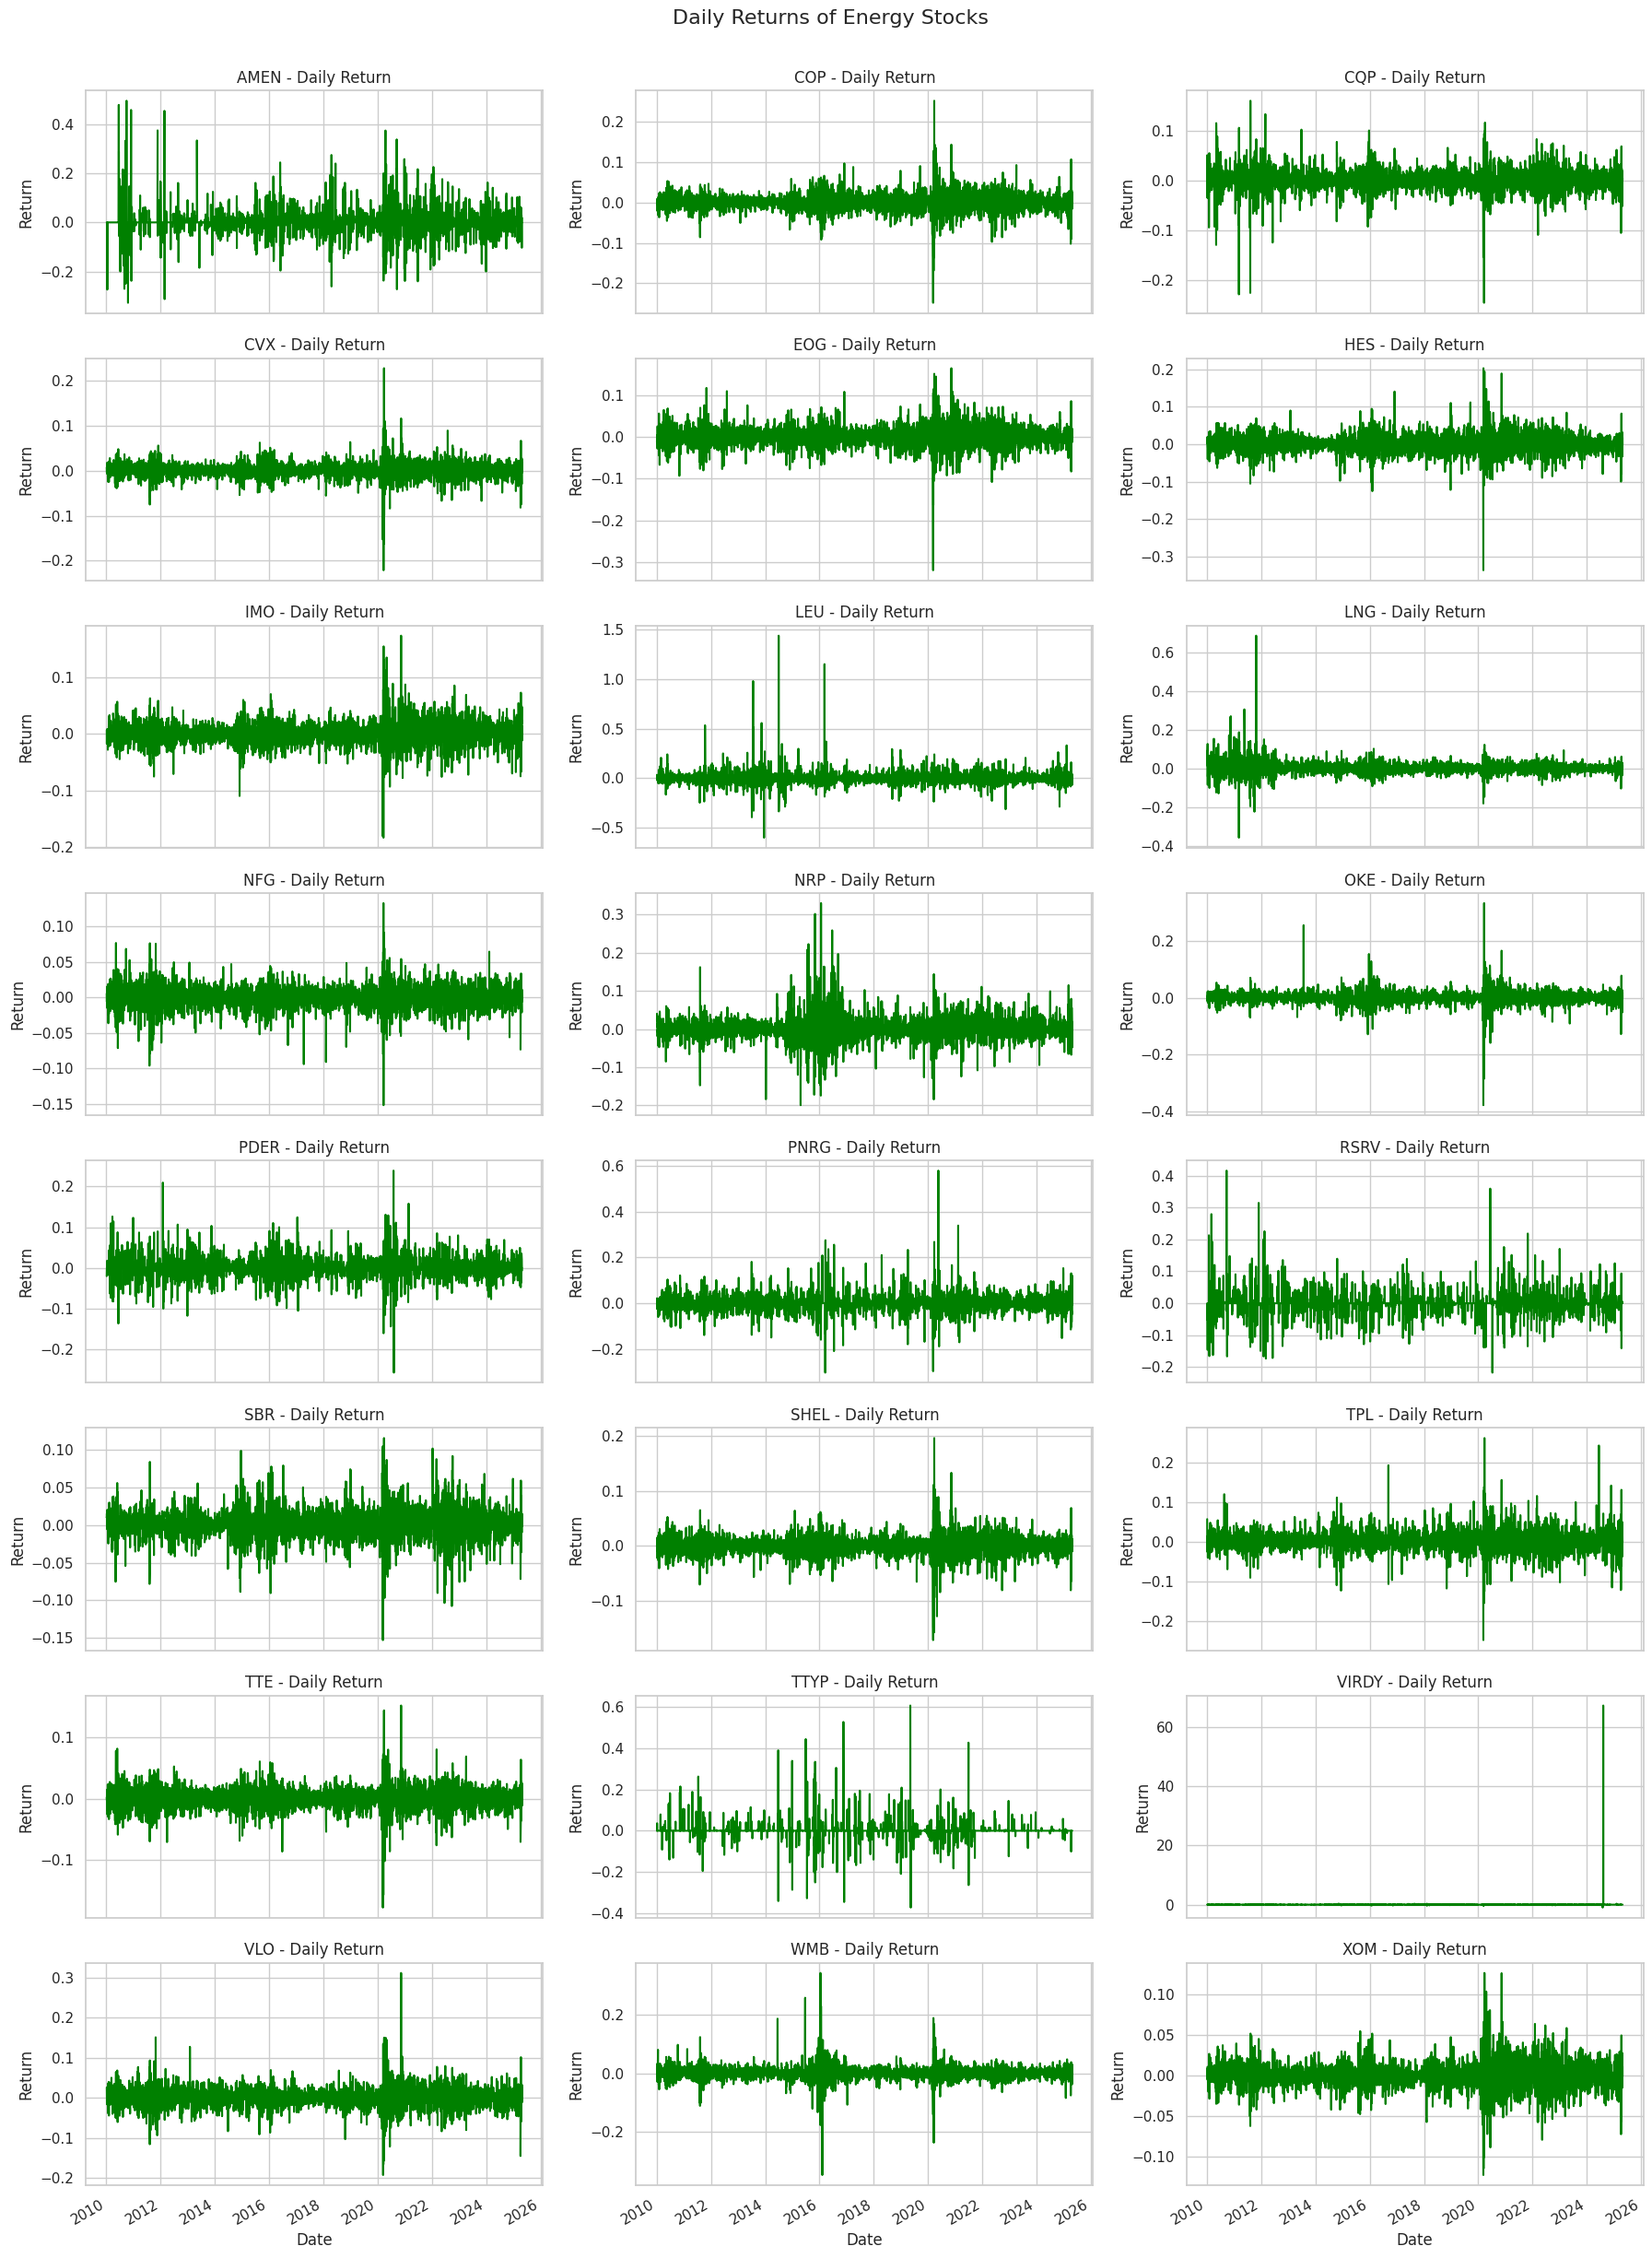

In [ ]:
# Plot Returns
fig2, axes2 = plt.subplots(rows, cols, figsize=(18, rows * 3), sharex=True)
axes2 = axes2.flatten()

for i, ticker in enumerate(tickers):
    ax = axes2[i]
    returns[ticker].plot(ax=ax, title=f"{ticker} - Daily Return", color='green')
    ax.set_ylabel("Return")
    ax.grid(True)

# Remove unused subplots
for j in range(i + 1, len(axes2)):
    fig2.delaxes(axes2[j])

plt.tight_layout()
plt.suptitle("Daily Returns of Energy Stocks", fontsize=16, y=1.02)
plt.show()


### 4.2 Correlation Heatmap

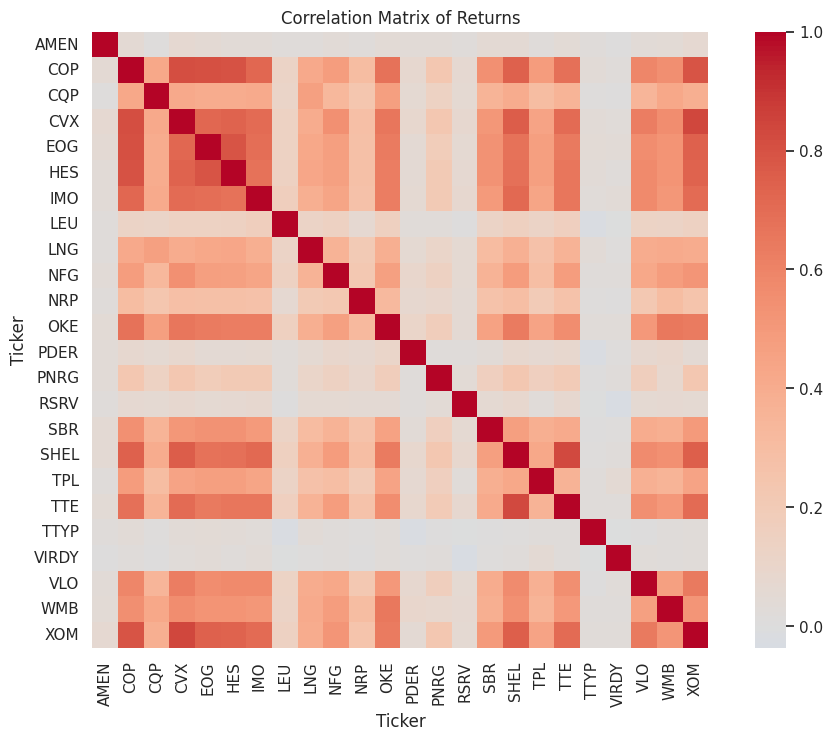

In [ ]:
plt.figure(figsize=(12, 8))
corr_matrix = returns.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix of Returns')
plt.show()


### 4.3 Volatility Analysis

In [ ]:
volatility= returns.std()
volatility

,0
Ticker,
AMEN,0.045779
COP,0.021412
CQP,0.022059
CVX,0.016969
EOG,0.023807
HES,0.025266
IMO,0.020588
LEU,0.067410
LNG,0.032153


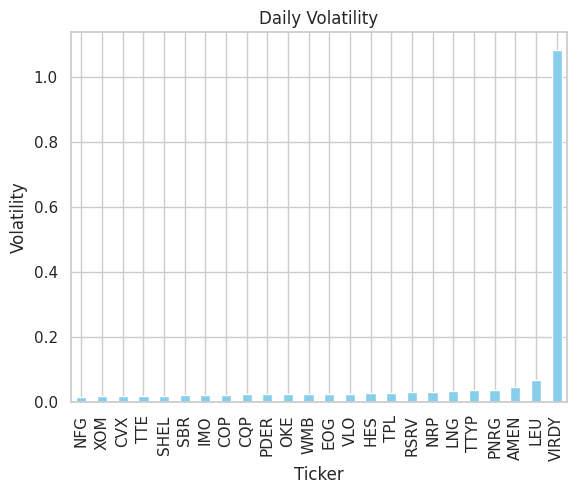

In [ ]:
volatility.sort_values().plot(kind='bar', color='skyblue', title="Daily Volatility")
plt.ylabel("Volatility")
plt.show()

<Axes: title={'center': 'Monthly Volatility'}, xlabel='Ticker'>

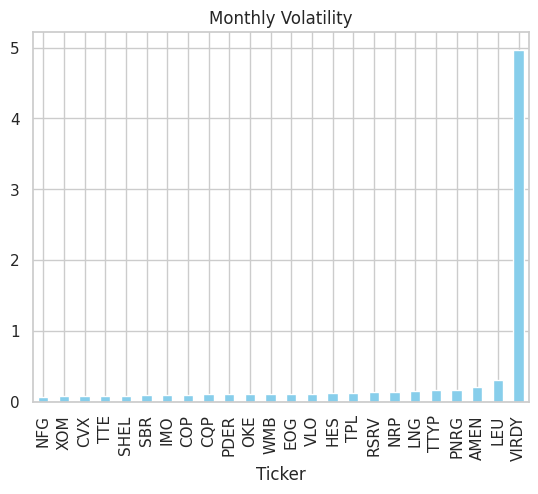

In [ ]:
volatility_month= returns.std()*np.sqrt(21)
volatility_month.sort_values().plot(kind='bar', color='skyblue', title="Monthly Volatility")

<Axes: title={'center': 'Yearly Volatility'}, xlabel='Ticker'>

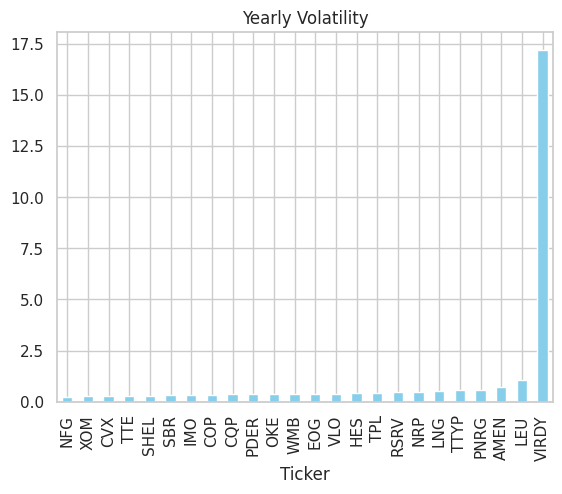

In [ ]:
volatility_annual= returns.std()*np.sqrt(252)
volatility_annual.sort_values().plot(kind='bar', color='skyblue', title="Yearly Volatility")

### 4.4 Cumulative Returns Plot

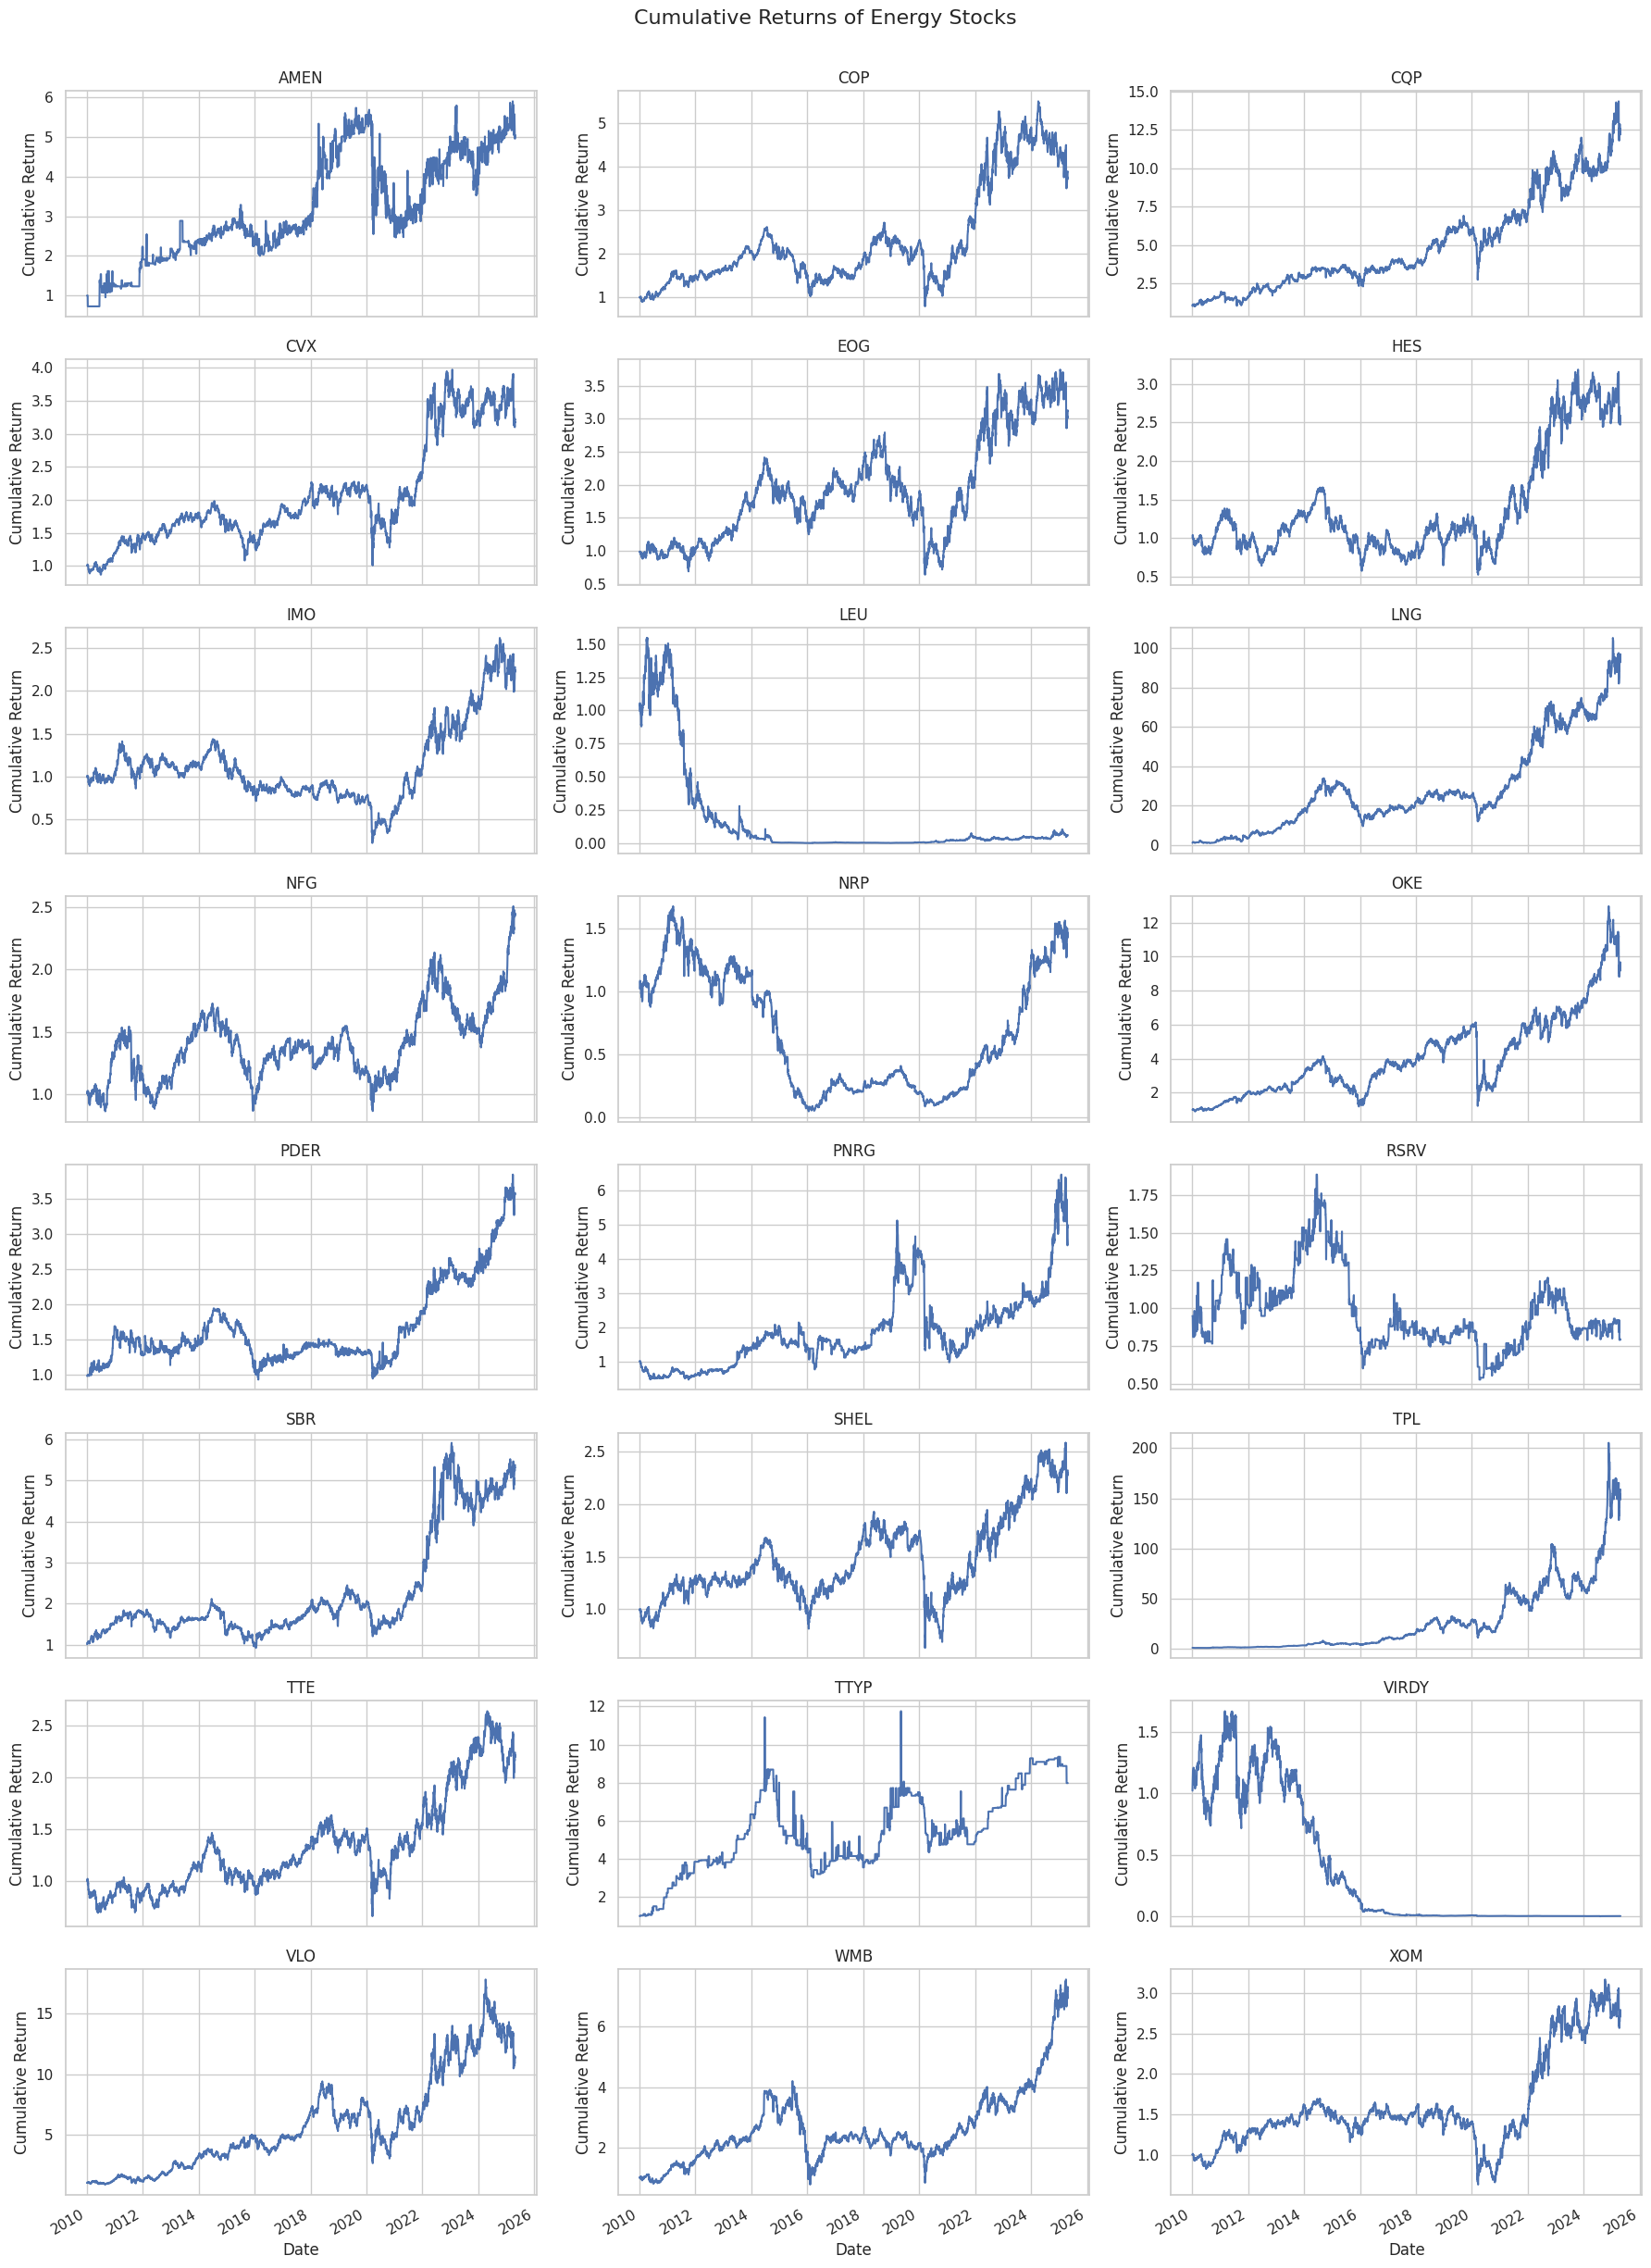

In [ ]:
cumulative_returns = (1 + returns).cumprod()

tickers = cumulative_returns.columns
num_tickers = len(tickers)

# Define subplot grid size (e.g., 3 columns)
cols = 3
rows = math.ceil(num_tickers / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 3), sharex=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, ticker in enumerate(tickers):
    ax = axes[i]
    cumulative_returns[ticker].plot(ax=ax, title=ticker)
    ax.set_ylabel("Cumulative Return")
    ax.grid(True)

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.suptitle("Cumulative Returns of Energy Stocks", fontsize=16, y=1.02)
plt.show()


## 4.5 Plot of Average Returns vs Volatility

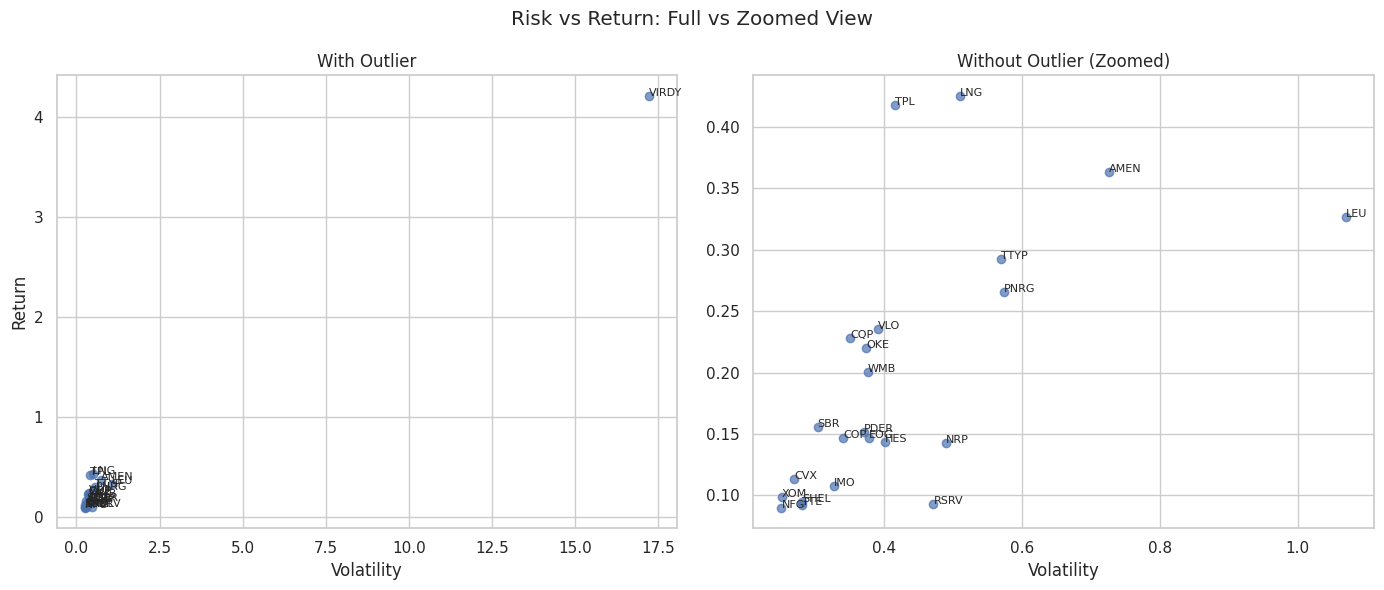

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot with outlier
avg_returns_all = returns.mean() * 252
volatility_all = returns.std() * np.sqrt(252)
axs[0].scatter(volatility_all, avg_returns_all, alpha=0.7)
for ticker in returns.columns:
    axs[0].text(volatility_all[ticker], avg_returns_all[ticker], ticker, fontsize=8)
axs[0].set_title('With Outlier')
axs[0].set_xlabel('Volatility')
axs[0].set_ylabel('Return')
axs[0].grid(True)

# Plot without outlier
returns_filtered = returns.drop(columns=["VIRDY"])
avg_returns_filt = returns_filtered.mean() * 252
volatility_filt = returns_filtered.std() * np.sqrt(252)
axs[1].scatter(volatility_filt, avg_returns_filt, alpha=0.7)
for ticker in returns_filtered.columns:
    axs[1].text(volatility_filt[ticker], avg_returns_filt[ticker], ticker, fontsize=8)
axs[1].set_title('Without Outlier (Zoomed)')
axs[1].set_xlabel('Volatility')
axs[1].grid(True)

plt.suptitle('Risk vs Return: Full vs Zoomed View')
plt.tight_layout()
plt.show()


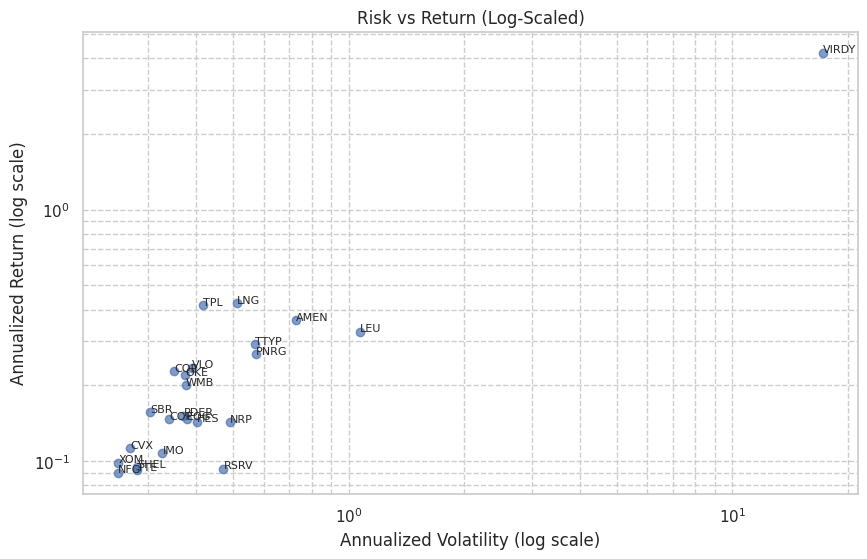

In [ ]:
avg_returns = returns.mean() * 252
volatility = returns.std() * np.sqrt(252)

plt.figure(figsize=(10, 6))
plt.scatter(volatility, avg_returns, alpha=0.7)
for ticker in returns.columns:
    plt.text(volatility[ticker], avg_returns[ticker], ticker, fontsize=8)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Annualized Volatility (log scale)')
plt.ylabel('Annualized Return (log scale)')
plt.title('Risk vs Return (Log-Scaled)')
plt.grid(True, which="both", ls="--")
plt.show()


<Axes: title={'center': 'Yearly Return'}, xlabel='Ticker'>

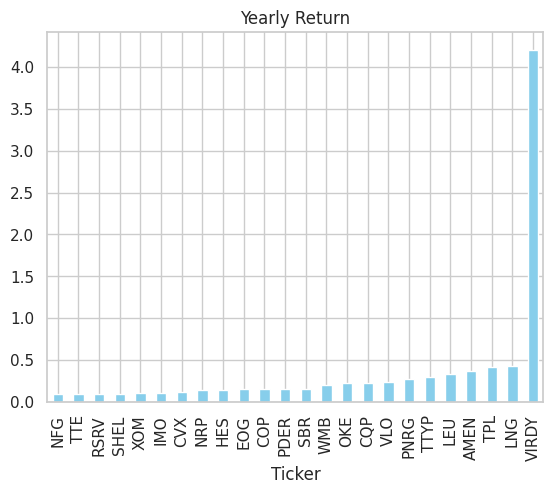

In [ ]:
avg_returns.sort_values().plot(kind='bar', color='skyblue', title="Yearly Return")

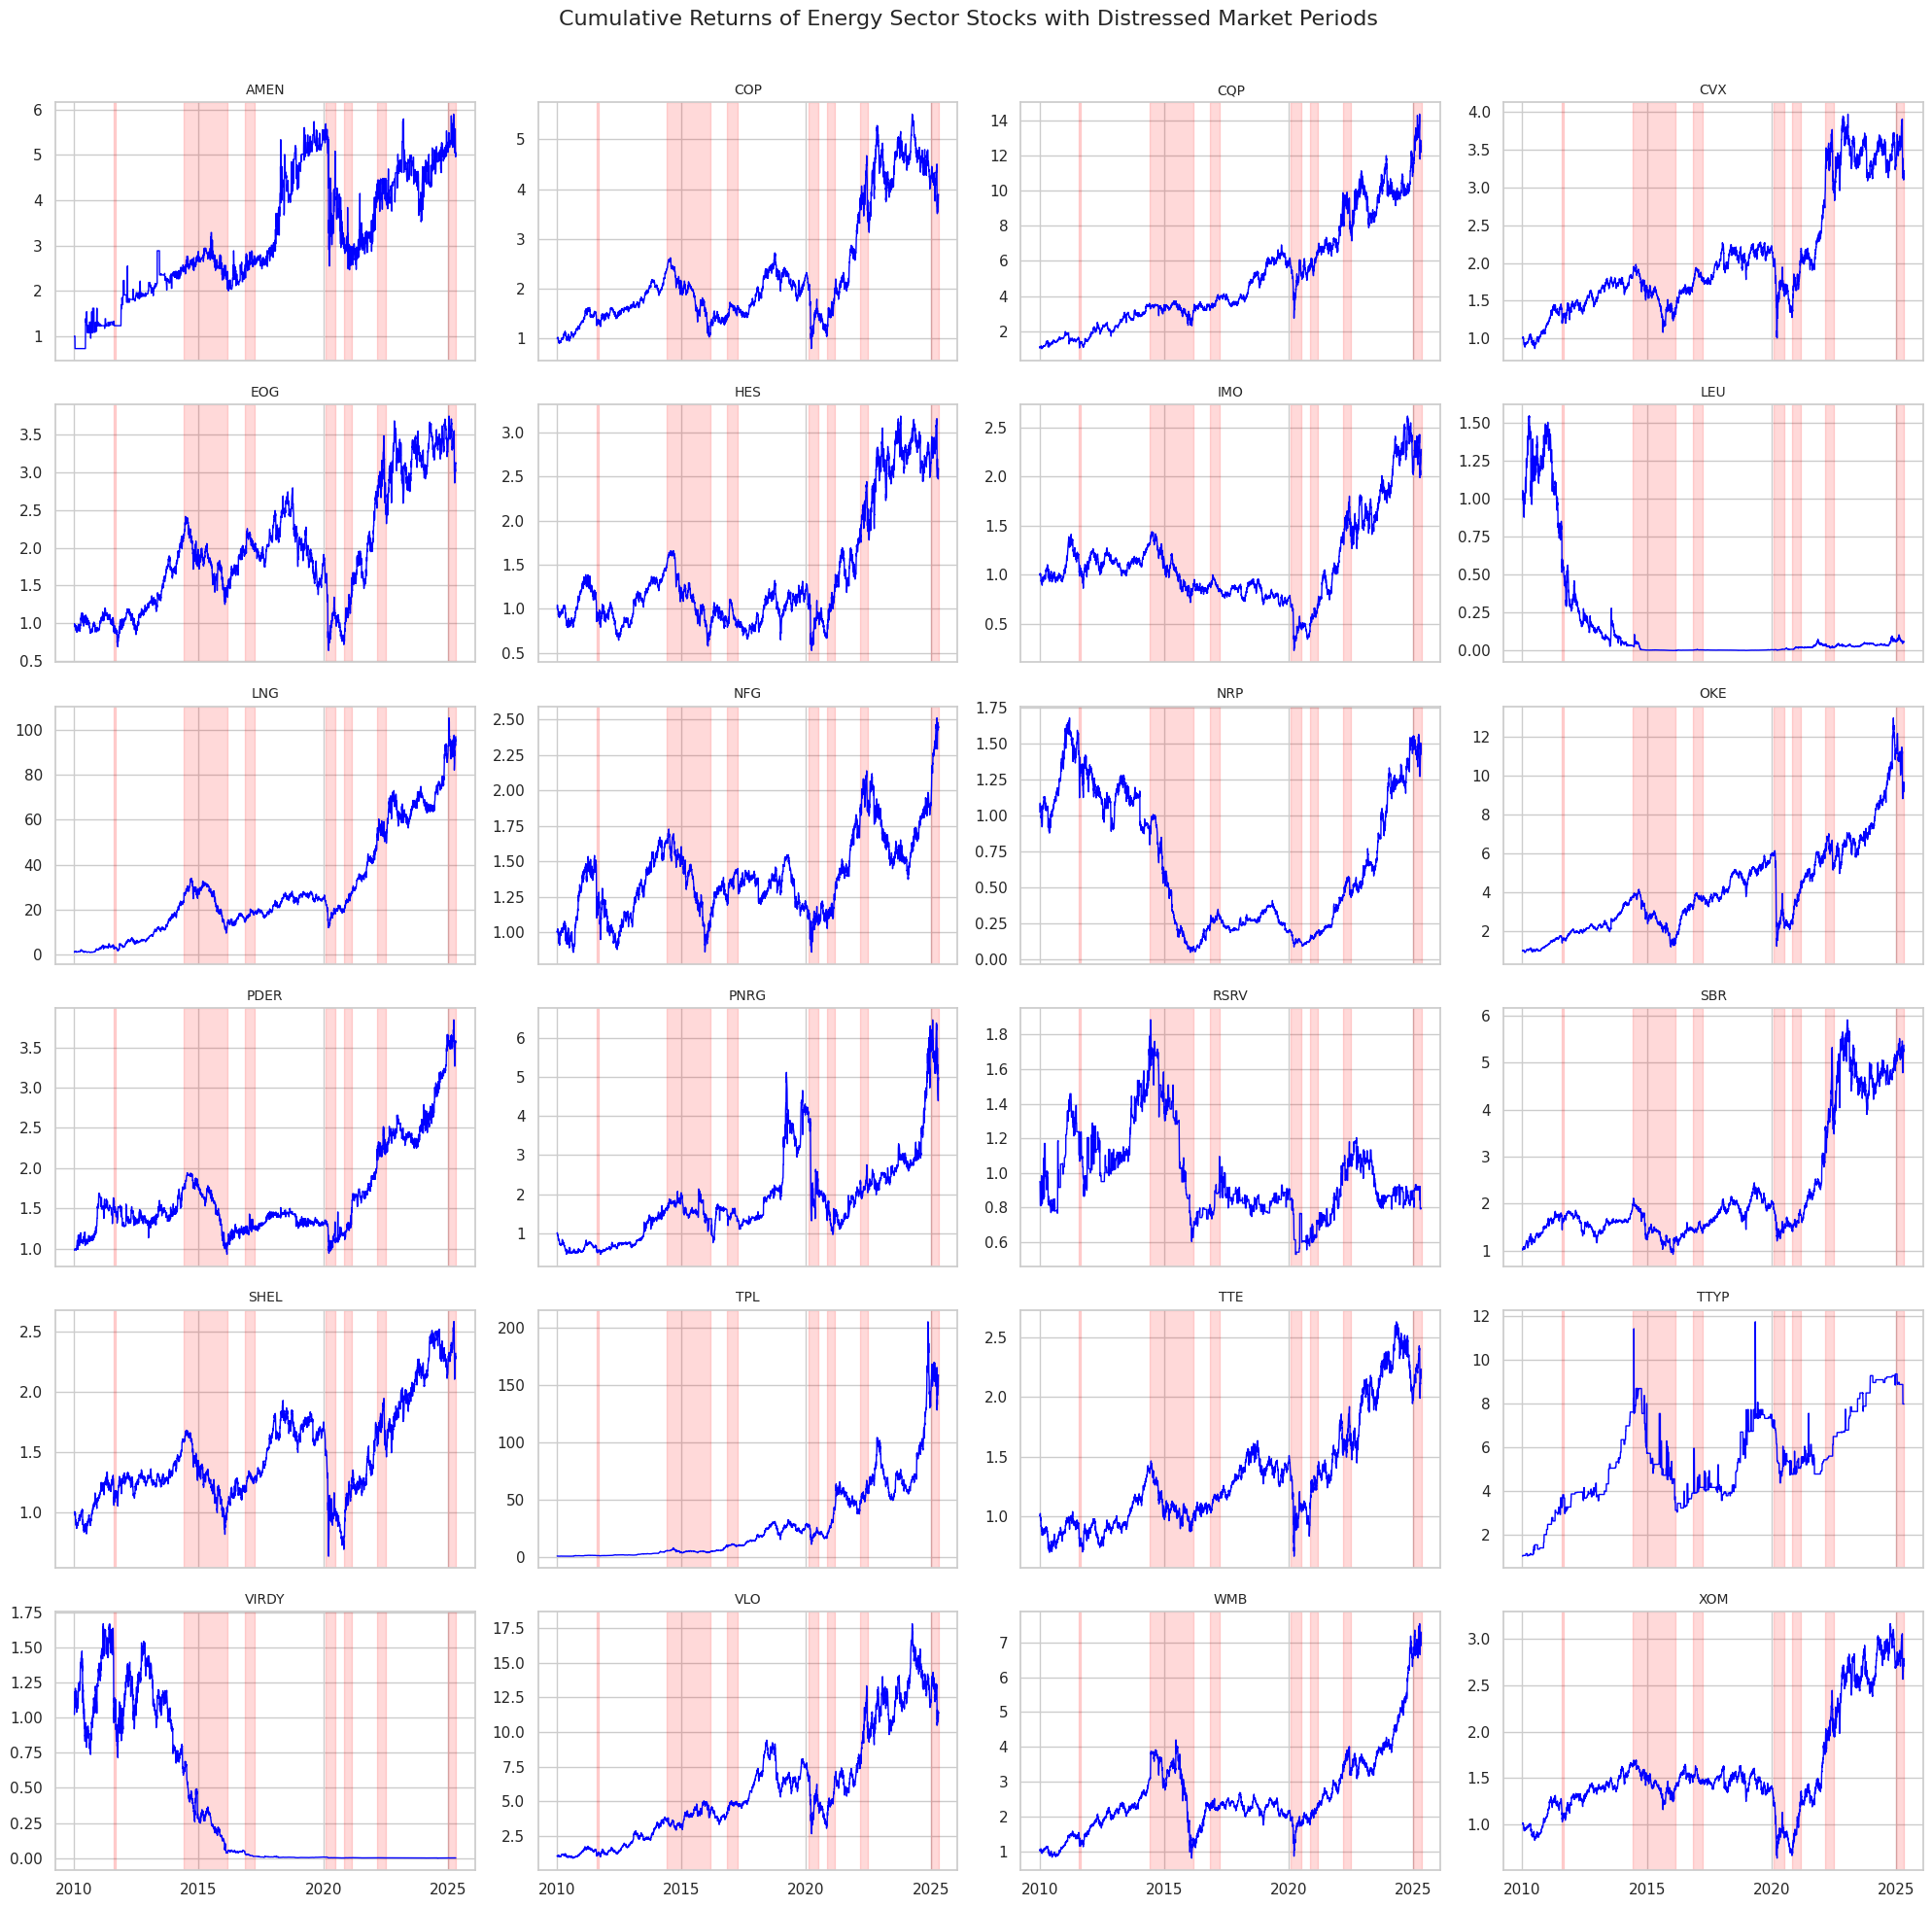

In [ ]:
# Assume cumulative_returns is already defined as (1 + returns).cumprod()
tickers = cumulative_returns.columns.tolist()

# Define distress periods
distressed_periods = [
    ("2011-08-01", "2011-08-31", "Debt Ceiling Crisis"),
    ("2014-06-01", "2016-02-29", "2015 Oil Crash"),
    ("2016-11-01", "2017-03-31", "Trump Transition"),
    ("2020-02-01", "2020-06-30", "COVID-19"),
    ("2020-11-01", "2021-02-28", "Biden Transition"),
    ("2022-03-01", "2022-06-30", "Russia-Ukraine + Sanctions"),
    ("2025-01-01", pd.Timestamp.today().strftime('%Y-%m-%d'), "2025 Tariff War"),
]

# Setup grid dimensions (6 rows x 4 columns = 24 plots per page)
n_rows, n_cols = 6, 4
total_plots = len(tickers)
pages = int(np.ceil(total_plots / (n_rows * n_cols)))

# Plot in pages
for page in range(pages):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20), sharex=True)
    axes = axes.flatten()

    start_idx = page * n_rows * n_cols
    end_idx = min(start_idx + n_rows * n_cols, total_plots)

    for i, idx in enumerate(range(start_idx, end_idx)):
        ticker = tickers[idx]
        ax = axes[i]

        # Plot cumulative return
        ax.plot(cumulative_returns.index, cumulative_returns[ticker], color='blue', linewidth=1)
        ax.set_title(ticker, fontsize=10)
        ax.grid(True)

        # Add shaded distress periods
        for start, end, label in distressed_periods:
            ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='red', alpha=0.15)

        # Format x-axis
        ax.xaxis.set_major_locator(mdates.YearLocator(5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("Cumulative Returns of Energy Sector Stocks with Distressed Market Periods", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


# 2. Feature Engineering
## Technical Indicators:
Moving averages (10d, 50d, 200d)

RSI (14d)

MACD

Bollinger Bands

In [ ]:
def calculate_technical_indicators(prices, window_short=10, window_moderate=50, window_long=200, window_rsi=14):
    features = pd.DataFrame(index=prices.index)

    for ticker in prices.columns:
        # Returns
        #features[f'{ticker}_return_1d'] = prices[ticker].pct_change()
        #features[f'{ticker}_return_5d'] = prices[ticker].pct_change(5)

        # Moving Averages
        features[f'{ticker}_ma_short'] = prices[ticker].rolling(window_short).mean()
        features[f'{ticker}_ma_moderate'] = prices[ticker].rolling(window_moderate).mean()
        features[f'{ticker}_ma_long'] = prices[ticker].rolling(window_long).mean()

        # RSI
        delta = prices[ticker].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window_rsi).mean()
        avg_loss = loss.rolling(window_rsi).mean()
        rs = avg_gain / avg_loss
        features[f'{ticker}_rsi'] = 100 - (100 / (1 + rs))

        # MACD
        ema12 = prices[ticker].ewm(span=12).mean()
        ema26 = prices[ticker].ewm(span=26).mean()
        features['macd'] = ema12 - ema26
        features['macd_signal'] = features['macd'].ewm(span=9).mean()

        # Bollinger Bands
        rolling_mean = prices[ticker].rolling(window=20).mean()
        rolling_std = prices[ticker].rolling(window=20).std()
        features[f'{ticker}_bollinger_upper'] = rolling_mean + (rolling_std * 2)
        features[f'{ticker}_bollinger_lower'] = rolling_mean - (rolling_std * 2)

    return features.dropna()

technical_features = calculate_technical_indicators(Prices)

<ipython-input-21-a0108d0caa41>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{ticker}_ma_long'] = prices[ticker].rolling(window_long).mean()
<ipython-input-21-a0108d0caa41>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{ticker}_rsi'] = 100 - (100 / (1 + rs))
<ipython-input-21-a0108d0caa41>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) 

Data Preparation

In [ ]:
# Parameters
HORIZON = 5  # Predicting returns over next 5 days
TEST_START = '2021-01-01'  # Out-of-sample period start
TRAIN_END = '2020-12-31'  # Training period end

features = technical_features.copy()

# 1. Prepare Targets - percentage returns over horizon period
def create_targets(prices, horizon):
    """Create multi-period forward returns"""
    returns = prices.pct_change(horizon).shift(-horizon)
    returns = returns.dropna()
    return returns
    #return prices.pct_change(horizon).shift(-horizon)

# Assuming 'prices' is your DataFrame of stock prices
targets = create_targets(Prices, HORIZON)

# 2. Align features and targets
common_idx = features.index.intersection(targets.index)
features = features.loc[common_idx]
targets = targets.loc[common_idx].dropna()  # Drop rows where target is NaN

# 3. Time-based split (no shuffling!)
X_train = features.loc[:TRAIN_END]
y_train = targets.loc[:TRAIN_END]
X_test = features.loc[TEST_START:]
y_test = targets.loc[TEST_START:]

# 4. Drop remaining NA rows (from technical indicators)
train_mask = X_train.isna().any(axis=1) | y_train.isna().any(axis=1)
X_train = X_train[~train_mask]
y_train = y_train[~train_mask]

test_mask = X_test.isna().any(axis=1) | y_test.isna().any(axis=1)
X_test = X_test[~test_mask]
y_test = y_test[~test_mask]

In [ ]:
y_test

Ticker,AMEN,COP,CQP,CVX,EOG,HES,IMO,LEU,LNG,NFG,...,RSRV,SBR,SHEL,TPL,TTE,TTYP,VIRDY,VLO,WMB,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,-0.020027,0.146323,0.054598,0.081336,0.195548,0.154167,0.115703,0.021556,0.138517,0.057454,...,0.000286,0.039917,0.117402,0.149281,0.066777,0.106061,0.191919,0.052216,0.070149,0.128675
2021-01-05,-0.020027,0.133366,0.093579,0.072873,0.158012,0.129112,0.032304,-0.000943,0.088900,0.048590,...,0.042857,0.059349,0.069592,0.108038,0.039328,0.106061,0.134615,0.038207,0.083052,0.100690
2021-01-06,0.054795,0.080901,0.075677,0.038419,0.098256,0.039679,-0.016159,-0.040661,0.049377,-0.003176,...,0.042857,0.022773,0.009184,0.051928,0.001098,0.106061,-0.034188,-0.015359,0.034418,0.085407
2021-01-07,-0.046076,0.070917,0.073554,0.058413,0.068379,0.042838,0.002726,0.104083,0.018833,-0.001815,...,0.042857,0.039715,0.032474,0.096689,-0.005412,0.000000,-0.066116,0.010056,0.053389,0.118995
2021-01-08,0.061805,0.009396,0.085754,0.011089,0.011710,0.013112,-0.034894,0.125510,0.032404,0.019102,...,0.042857,0.008160,-0.001242,0.049925,-0.036384,0.000000,-0.066667,0.010224,0.056338,0.053454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-11,-0.065777,0.013428,-0.006709,-0.014009,0.014454,-0.016965,0.036274,-0.026577,0.013753,0.011117,...,0.000000,0.031368,0.041230,0.010412,0.029522,0.000000,0.000000,-0.016802,0.000887,0.021427
2025-04-14,-0.080908,0.038288,-0.011415,0.014632,0.043656,0.019310,0.092765,0.005550,0.036770,0.008122,...,0.005457,0.036275,0.042053,0.050420,0.046520,0.000000,0.000000,0.019306,0.014644,0.047490
2025-04-15,-0.080908,0.049113,-0.011033,0.015906,0.047556,0.022168,0.101887,0.056707,0.005023,-0.003461,...,0.005457,0.021263,0.027557,0.052544,0.035821,0.000000,0.000000,0.064621,-0.001025,0.041416



Train Set Performance:
AMEN: MSE=0.001210, R²=0.7538
COP: MSE=0.000374, R²=0.8429
CQP: MSE=0.000416, R²=0.8225
CVX: MSE=0.000237, R²=0.8424
EOG: MSE=0.000564, R²=0.8082
HES: MSE=0.000645, R²=0.8196
IMO: MSE=0.000371, R²=0.8560
LEU: MSE=0.004214, R²=0.8919
LNG: MSE=0.000737, R²=0.8327
NFG: MSE=0.000221, R²=0.8093
NRP: MSE=0.001045, R²=0.8257
OKE: MSE=0.000510, R²=0.8667
PDER: MSE=0.000396, R²=0.7567
PNRG: MSE=0.001022, R²=0.8304
RSRV: MSE=0.000628, R²=0.7860
SBR: MSE=0.000373, R²=0.7809
SHEL: MSE=0.000281, R²=0.8613
TPL: MSE=0.000614, R²=0.8157
TTE: MSE=0.000280, R²=0.8542
TTYP: MSE=0.001385, R²=0.7987
VIRDY: MSE=0.001968, R²=0.8392
VLO: MSE=0.000529, R²=0.8367
WMB: MSE=0.000518, R²=0.8434
XOM: MSE=0.000210, R²=0.8191


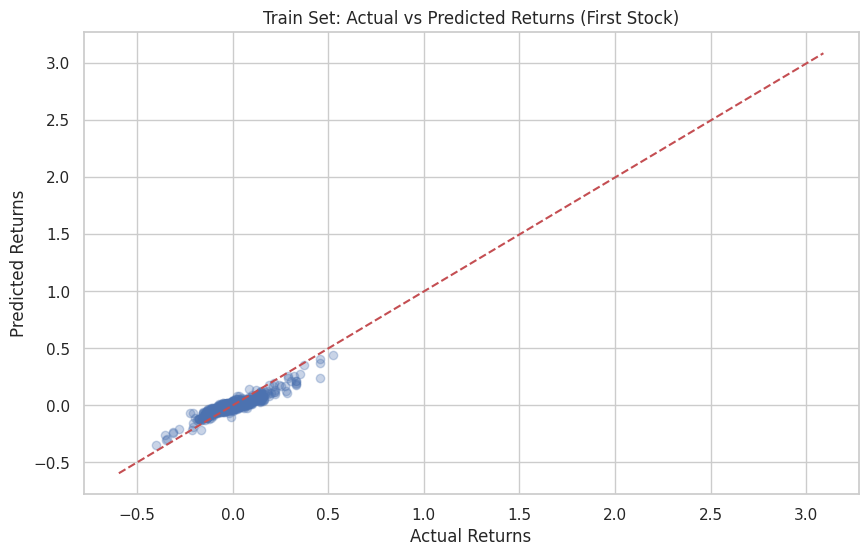


Test Set Performance:
AMEN: MSE=0.009301, R²=-1.0139
COP: MSE=0.012192, R²=-3.7542
CQP: MSE=0.005944, R²=-1.7928
CVX: MSE=0.012061, R²=-7.3375
EOG: MSE=0.053017, R²=-17.2740
HES: MSE=0.076337, R²=-23.7120
IMO: MSE=0.006447, R²=-1.4909
LEU: MSE=0.035593, R²=-2.1856
LNG: MSE=0.006394, R²=-2.6692
NFG: MSE=0.006024, R²=-5.5702
NRP: MSE=0.032548, R²=-10.9597
OKE: MSE=0.015580, R²=-8.7545
PDER: MSE=0.001766, R²=-0.5821
PNRG: MSE=0.008835, R²=-0.6670
RSRV: MSE=0.007271, R²=-2.0488
SBR: MSE=0.007184, R²=-1.7182
SHEL: MSE=0.012540, R²=-8.3865
TPL: MSE=0.018212, R²=-2.7405
TTE: MSE=0.007486, R²=-4.9925
TTYP: MSE=0.046224, R²=-26.9036
VIRDY: MSE=35.679175, R²=-0.0106
VLO: MSE=0.019155, R²=-5.9880
WMB: MSE=0.015686, R²=-15.0613
XOM: MSE=0.010037, R²=-5.0345


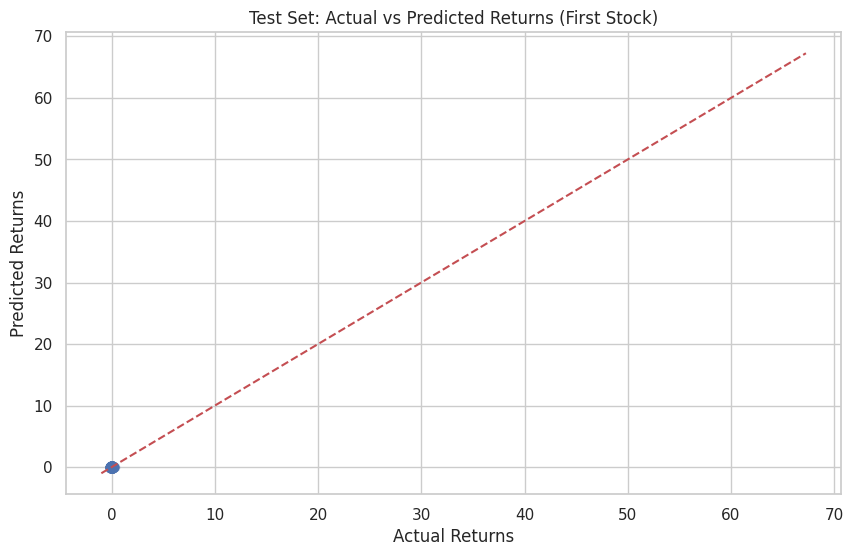

In [ ]:
# 5. Initialize and train model - MultiOutput for all stocks
model = MultiOutputRegressor(
    GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        min_samples_split=10,
        random_state=42
    ),
    n_jobs=-1
)

model.fit(X_train, y_train)

# 6. Evaluate
def evaluate_model(model, X, y, set_name="Train"):
    preds = model.predict(X)

    # Calculate returns for each stock
    mse = mean_squared_error(y, preds, multioutput='raw_values')
    r2 = r2_score(y, preds, multioutput='raw_values')

    print(f"\n{set_name} Set Performance:")
    for i, stock in enumerate(y.columns):
        print(f"{stock}: MSE={mse[i]:.6f}, R²={r2[i]:.4f}")

    # Plot actual vs predicted for one stock as example
    plt.figure(figsize=(10, 6))
    plt.scatter(y.iloc[:, 0], preds[:, 0], alpha=0.3)
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.title(f'{set_name} Set: Actual vs Predicted Returns (First Stock)')
    plt.plot([y.min().min(), y.max().max()],
             [y.min().min(), y.max().max()], 'r--')
    plt.show()

    return preds

train_preds = evaluate_model(model, X_train, y_train, "Train")
test_preds = evaluate_model(model, X_test, y_test, "Test")

In [ ]:
# Parameters
HORIZON = 5  # Predicting returns over next 5 days
TEST_START = '2021-01-01'  # Out-of-sample period start
TRAIN_END = '2020-12-31'  # Training period end

features = technical_features.copy()

# 1. First ensure your target calculation is correct
def create_proper_targets(prices, horizon=5):
    """Calculate future rolling returns properly"""
    # Calculate future returns: (price_t+horizon - price_t)/price_t
    future_prices = Prices.shift(-horizon)
    # Calculate returns: (price_t+horizon - price_t)/price_t
    returns = (future_prices - Prices) / Prices
    return returns

targets = create_proper_targets(Prices, HORIZON)


# 2. Align features and targets BEFORE splitting
common_idx = features.index.intersection(targets.index)
features_aligned = features.loc[common_idx]
targets_aligned = targets.loc[common_idx]

# 3. Drop rows with any NA values (in either features or targets)
valid_mask = ~(features_aligned.isna().any(axis=1)) | ~(targets_aligned.isna().any(axis=1))
features_clean = features_aligned[valid_mask]
targets_clean = targets_aligned[valid_mask]

# 4. Time-based split
split_date = '2021-01-01'
X_train = features_clean.loc[:split_date]
y_train = targets_clean.loc[:split_date]
X_test = features_clean.loc[split_date:]
y_test = targets_clean.loc[split_date:]

# 5. Final validation
print(f"X_train length: {len(X_train)}, y_train length: {len(y_train)}")
print(f"X_test length: {len(X_test)}, y_test length: {len(y_test)}")
print(f"Are lengths equal? {len(X_test) == len(y_test)}")

# Should output:
# X_train length: [some number], y_train length: [same number]
# X_test length: [some number], y_test length: [same number]
# Are lengths equal? True

X_train length: 1833, y_train length: 1833
X_test length: 638, y_test length: 638
Are lengths equal? True



Train Set Performance:
AMEN: MSE=0.001223, R²=0.7510
COP: MSE=0.000382, R²=0.8396
CQP: MSE=0.000430, R²=0.8162
CVX: MSE=0.000232, R²=0.8457
EOG: MSE=0.000563, R²=0.8085
HES: MSE=0.000661, R²=0.8150
IMO: MSE=0.000366, R²=0.8580
LEU: MSE=0.004285, R²=0.8901
LNG: MSE=0.000721, R²=0.8364
NFG: MSE=0.000215, R²=0.8151
NRP: MSE=0.001005, R²=0.8325
OKE: MSE=0.000480, R²=0.8746
PDER: MSE=0.000387, R²=0.7617
PNRG: MSE=0.001046, R²=0.8264
RSRV: MSE=0.000643, R²=0.7808
SBR: MSE=0.000362, R²=0.7871
SHEL: MSE=0.000275, R²=0.8644
TPL: MSE=0.000603, R²=0.8192
TTE: MSE=0.000285, R²=0.8520
TTYP: MSE=0.001390, R²=0.7981
VIRDY: MSE=0.002042, R²=0.8332
VLO: MSE=0.000542, R²=0.8327
WMB: MSE=0.000519, R²=0.8430
XOM: MSE=0.000198, R²=0.8292


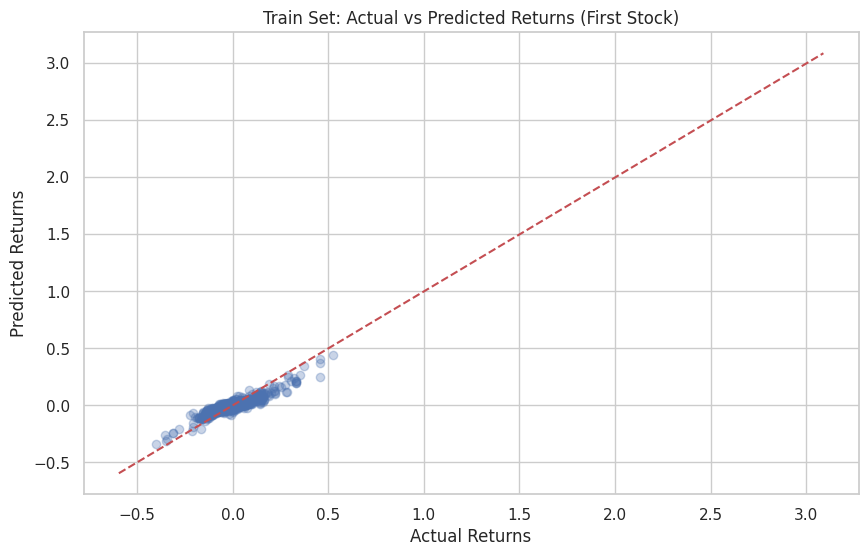

ValueError: Input contains NaN.

In [ ]:
# 5. Initialize and train model - MultiOutput for all stocks
model = MultiOutputRegressor(
    GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        min_samples_split=10,
        random_state=42
    ),
    n_jobs=-1
)

model.fit(X_train, y_train)

# 6. Evaluate
def evaluate_model(model, X, y, set_name="Train"):
    preds = model.predict(X)

    # Calculate returns for each stock
    mse = mean_squared_error(y, preds, multioutput='raw_values')
    r2 = r2_score(y, preds, multioutput='raw_values')

    print(f"\n{set_name} Set Performance:")
    for i, stock in enumerate(y.columns):
        print(f"{stock}: MSE={mse[i]:.6f}, R²={r2[i]:.4f}")

    # Plot actual vs predicted for one stock as example
    plt.figure(figsize=(10, 6))
    plt.scatter(y.iloc[:, 0], preds[:, 0], alpha=0.3)
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.title(f'{set_name} Set: Actual vs Predicted Returns (First Stock)')
    plt.plot([y.min().min(), y.max().max()],
             [y.min().min(), y.max().max()], 'r--')
    plt.show()

    return preds

train_preds = evaluate_model(model, X_train, y_train, "Train")
test_preds = evaluate_model(model, X_test, y_test, "Test")

In [ ]:
# 1. First ensure your target calculation is correct
def create_proper_targets(prices, horizon=5):
    """Calculate future rolling returns properly"""
    # Calculate future returns: (price_t+horizon - price_t)/price_t
    future_prices = prices.shift(-horizon)
    returns = (future_prices - prices) / prices
    return returns

targets = create_proper_targets(Prices, HORIZON)

# 2. Align features and targets BEFORE splitting
common_idx = features.index.intersection(targets.index)
features_aligned = features.loc[common_idx]
targets_aligned = targets.loc[common_idx]

# 3. Drop rows with any NA values (in either features or targets)
valid_mask = ~(features_aligned.isna().any(axis=1)) | ~(targets_aligned.isna().any(axis=1))
features_clean = features_aligned[valid_mask]
targets_clean = targets_aligned[valid_mask]

# 4. Time-based split
split_date = '2021-01-01'
X_train = features_clean.loc[:split_date]
y_train = targets_clean.loc[:split_date]
X_test = features_clean.loc[split_date:]
y_test = targets_clean.loc[split_date:]

# 5. Final validation
print(f"X_train length: {len(X_train)}, y_train length: {len(y_train)}")
print(f"X_test length: {len(X_test)}, y_test length: {len(y_test)}")
print(f"Are lengths equal? {len(X_test) == len(y_test)}")

X_train length: 1833, y_train length: 1833
X_test length: 638, y_test length: 638
Are lengths equal? True


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Parameters
HORIZON = 5  # Predicting returns over next 5 days
TEST_START = '2021-01-01'  # Out-of-sample period start
TRAIN_END = '2020-12-31'  # Training period end

# 1. Create targets properly
def create_proper_targets(prices, horizon):
    """Calculate future percentage returns without lookahead"""
    return prices.pct_change(horizon).shift(-horizon)

targets = create_proper_targets(Prices, HORIZON)

# 2. Align features and targets
common_idx = features.index.intersection(targets.index)
features = features.loc[common_idx]
targets = targets.loc[common_idx]

# 3. Handle missing values - more robust approach
def clean_data(X, y):
    """Remove or impute missing values"""
    # First drop rows where target is NA (these can't be used)
    valid_mask = ~y.isna().any(axis=1)
    X_clean = X[valid_mask]
    y_clean = y[valid_mask]

    # Then handle feature NAs - either impute or drop
    if X_clean.isna().sum().sum() > 0:
        print(f"Imputing {X_clean.isna().sum().sum()} missing values in features")
        imputer = IterativeImputer(random_state=42)
        X_clean = pd.DataFrame(imputer.fit_transform(X_clean),
                              columns=X_clean.columns,
                              index=X_clean.index)
    return X_clean, y_clean

# 4. Time-based split with cleaning
X_train, y_train = clean_data(features.loc[:TRAIN_END], targets.loc[:TRAIN_END])
X_test, y_test = clean_data(features.loc[TEST_START:], targets.loc[TEST_START:])

# Verify no NAs remain
assert not X_train.isna().any().any(), "Training features still contain NAs"
assert not y_train.isna().any().any(), "Training targets still contain NAs"
assert not X_test.isna().any().any(), "Test features still contain NAs"
assert not y_test.isna().any().any(), "Test targets still contain NAs"

# 5. Initialize and train model
model = MultiOutputRegressor(
    GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        min_samples_split=10,
        random_state=42
    ),
    n_jobs=-1
)

model.fit(X_train, y_train)

# 6. Evaluation function with NaN checks
def safe_evaluate_model(model, X, y, set_name="Train"):
    """Evaluation with additional data validation"""
    # Final NaN check
    if X.isna().any().any() or y.isna().any().any():
        raise ValueError(f"{set_name} set contains NaN values")

    preds = model.predict(X)

    # Calculate metrics for each stock
    mse = mean_squared_error(y, preds, multioutput='raw_values')
    r2 = r2_score(y, preds, multioutput='raw_values')

    print(f"\n{set_name} Set Performance:")
    for i, stock in enumerate(y.columns):
        print(f"{stock}: MSE={mse[i]:.6f}, R²={r2[i]:.4f}")

    return preds

# 7. Run evaluation
try:
    train_preds = safe_evaluate_model(model, X_train, y_train, "Train")
    test_preds = safe_evaluate_model(model, X_test, y_test, "Test")
except ValueError as e:
    print(f"Evaluation failed: {str(e)}")
    print("Debugging info:")
    print("X_train NA count:", X_train.isna().sum().sum())
    print("y_train NA count:", y_train.isna().sum().sum())
    print("X_test NA count:", X_test.isna().sum().sum())
    print("y_test NA count:", y_test.isna().sum().sum())


Train Set Performance:
AMEN: MSE=0.001215, R²=0.7526
COP: MSE=0.000384, R²=0.8384
CQP: MSE=0.000430, R²=0.8164
CVX: MSE=0.000240, R²=0.8405
EOG: MSE=0.000554, R²=0.8118
HES: MSE=0.000667, R²=0.8135
IMO: MSE=0.000365, R²=0.8581
LEU: MSE=0.004354, R²=0.8884
LNG: MSE=0.000740, R²=0.8321
NFG: MSE=0.000213, R²=0.8163
NRP: MSE=0.001033, R²=0.8277
OKE: MSE=0.000484, R²=0.8735
PDER: MSE=0.000382, R²=0.7650
PNRG: MSE=0.001008, R²=0.8328
RSRV: MSE=0.000642, R²=0.7811
SBR: MSE=0.000362, R²=0.7870
SHEL: MSE=0.000275, R²=0.8643
TPL: MSE=0.000584, R²=0.8248
TTE: MSE=0.000279, R²=0.8548
TTYP: MSE=0.001417, R²=0.7941
VIRDY: MSE=0.001986, R²=0.8377
VLO: MSE=0.000531, R²=0.8360
WMB: MSE=0.000524, R²=0.8418
XOM: MSE=0.000207, R²=0.8217

Test Set Performance:
AMEN: MSE=0.011592, R²=-1.5075
COP: MSE=0.013448, R²=-4.2438
CQP: MSE=0.005815, R²=-1.7323
CVX: MSE=0.016054, R²=-10.0977
EOG: MSE=0.047051, R²=-15.2178
HES: MSE=0.058777, R²=-18.0273
IMO: MSE=0.007125, R²=-1.7527
LEU: MSE=0.033299, R²=-1.9803
LNG: 